### 1. Eksplorasi & Preprocessing

Import Library dan Pembatasan Jumlah Data

Bagian ini berfungsi untuk memuat seluruh library yang dibutuhkan untuk pemrosesan data, analisis teks, visualisasi, hingga pemodelan machine learning. Dataset dibatasi hanya hingga 100.000 baris meskipun data asli berukuran jauh lebih besar.

Pembatasan ini dilakukan untuk menjaga:
- Stabilitas memori (RAM)
- Kecepatan eksekusi notebook
- Efisiensi proses eksperimen

Jumlah 100.000 baris sudah cukup representatif untuk menangkap pola bahasa dan distribusi ancaman dalam dataset email, sekaligus menjaga waktu training tetap realistis untuk lingkungan akademik dan eksperimen lokal.

Library yang digunakan mencakup:
- pandas dan numpy untuk manipulasi data
- matplotlib dan seaborn untuk visualisasi
- email dan re untuk parsing dan pembersihan teks
- nltk untuk stopwords
- scikit-learn untuk pemodelan
- tqdm untuk pemantauan progres proses besar

Pendekatan ini merupakan keseimbangan antara akurasi model dan efisiensi komputasi.


In [1]:
# Cell 1: Import Library & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import email
import re
import nltk
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import time

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Data (50k baris)
FILE_PATH = 'emails.csv' 
try:
    print("[INFO] Loading 100,000 rows...")
    df = pd.read_csv(FILE_PATH, nrows=100000)
    print(f"[SUCCESS] Data Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("[ERROR] File 'emails.csv' tidak ditemukan.")

# Parsing Email Raw
def parse_raw_message(raw_message):
    try:
        msg = email.message_from_string(raw_message)
        content = []
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                payload = part.get_payload()
                if payload: content.append(payload)
        return {
            'subject': str(msg.get('Subject', '')),
            'date': str(msg.get('Date', '')),
            'body': ''.join(content)
        }
    except:
        return {'subject': '', 'date': '', 'body': ''}

print("[INFO] Parsing raw email messages...")
tqdm.pandas()
parsed_data = df['message'].progress_apply(parse_raw_message)
df_parsed = pd.DataFrame(list(parsed_data))

# Hapus variabel lama untuk hemat RAM
del df
import gc; gc.collect()

print("[INFO] Sample Data Terparsing:")
df_parsed.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[INFO] Loading 100,000 rows...
[SUCCESS] Data Loaded. Shape: (100000, 2)
[INFO] Parsing raw email messages...


100%|██████████| 100000/100000 [00:06<00:00, 14911.27it/s]


[INFO] Sample Data Terparsing:


,subject,date,body
0,,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",Here is our forecast\n\n
1,Re:,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Traveling to have a business meeting takes the...
2,Re: test,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",test successful. way to go!!!
3,,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)","Randy,\n\n Can you send me a schedule of the s..."
4,Re: Hello,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Let's shoot for Tuesday at 11:45.
5,Re: Hello,"Thu, 31 Aug 2000 04:17:00 -0700 (PDT)","Greg,\n\n How about either next Tuesday or Thu..."
6,,"Tue, 22 Aug 2000 07:44:00 -0700 (PDT)",Please cc the following distribution list with...
7,Re: PRC review - phone calls,"Fri, 14 Jul 2000 06:59:00 -0700 (PDT)",any morning between 10 and 11:30
8,Re: High Speed Internet Access,"Tue, 17 Oct 2000 02:26:00 -0700 (PDT)",1. login: pallen pw: ke9davis\n\n I don't thi...
9,FW: fixed forward or other Collar floor gas pr...,"Mon, 16 Oct 2000 06:44:00 -0700 (PDT)",---------------------- Forwarded by Phillip K ...


## 2. Parsing Email Mentah Menjadi Struktur Terpisah

Dataset email masih berbentuk pesan mentah yang menggabungkan header dan isi pesan dalam satu string panjang. Fungsi `parse_raw_message()` memisahkan informasi penting menjadi tiga kolom utama:
- subject
- date
- body

Pemisahan ini penting karena:
- Subject dan body memiliki karakteristik bahasa yang berbeda
- Tanggal diperlukan untuk membangun fitur berbasis waktu
- Body menjadi sumber utama fitur teks untuk TF-IDF

Setelah parsing selesai, variabel dataset awal dihapus dari memori untuk menghindari pemborosan RAM. Langkah ini penting karena ukuran dataset relatif besar dan seluruh proses lanjutan menggunakan data hasil parsing.

## 3. Pembuatan Label `warning` Menggunakan Keyword-Based Labeling

Dataset Enron tidak memiliki label ancaman bawaan. Oleh karena itu dibuat sistem pelabelan otomatis berbasis keyword untuk membentuk ground truth awal.

Tiga kategori utama yang digunakan:
- fraud: kejahatan finansial
- phishing: pencurian kredensial
- threat: ancaman langsung

Jika salah satu kategori terdeteksi dalam subject atau body, maka email diberi label:
- 1 untuk berbahaya
- 0 untuk aman

Metode ini dikenal sebagai weak supervision, yaitu teknik pelabelan otomatis berbasis aturan yang umum digunakan ketika data berlabel tidak tersedia.

Pendekatan ini dipilih karena:
- Skalabel untuk ratusan ribu data
- Konsisten secara logika
- Tidak membutuhkan pelabelan manual yang mahal dan lama

## 4. Feature Engineering Metadata Email

Empat fitur tambahan dibuat dari metadata email:
- hour: jam pengiriman email
- is_weekend: indikator hari libur
- body_len: panjang karakter email
- caps_ratio: rasio huruf kapital

Fitur ini ditambahkan karena banyak email berbahaya memiliki pola perilaku tertentu, seperti:
- Dikirim di luar jam kerja
- Mengandung banyak huruf kapital untuk menekan psikologis korban
- Panjang teks yang ekstrem (sangat pendek atau sangat panjang)

Dengan menambahkan fitur numerik ini, model tidak hanya bergantung pada isi teks, tetapi juga pola perilaku pengirim.

## 5. Pembersihan Teks dan Penghapusan Stopwords

Fungsi pembersihan teks melakukan:
- Lowercasing
- Penghapusan angka dan simbol
- Penghapusan stopwords bahasa Inggris

Pembersihan ini penting karena:
- TF-IDF sangat sensitif terhadap noise
- Stopwords tidak memiliki makna klasifikasi
- Simbol dan angka menambah dimensi fitur tanpa informasi yang relevan

Hasilnya adalah representasi teks yang lebih bersih, lebih ringkas, dan lebih informatif untuk model.


In [2]:
# Cell 2: Feature Engineering & Create 'warning' Column

# Definisi Keywords untuk Labeling Otomatis (Ground Truth)
KEYWORDS = {
    'fraud': ['bank', 'fund', 'offshore', 'secret', 'confidential', 'bribe', 'fraud', 'illegal', 'laundering', 'bitcoin', 'btc'],
    'phishing': ['verify', 'account', 'password', 'urgent', 'click', 'suspended', 'security', 'alert', 'login', 'update'],
    'threat': ['kill', 'ruin', 'exposed', 'blackmail', 'warning', 'ending', 'career', 'dead', 'destroy', 'or else']
}

def create_warning_label(row):
    text = (str(row['subject']) + " " + str(row['body'])).lower()
    
    is_fraud = any(k in text for k in KEYWORDS['fraud'])
    is_phishing = any(k in text for k in KEYWORDS['phishing'])
    is_threat = any(k in text for k in KEYWORDS['threat'])
    
    # Target Variable: 'warning' (1 = Dangerous, 0 = Safe)
    label = 1 if (is_fraud or is_phishing or is_threat) else 0
    
    return pd.Series([label, int(is_fraud), int(is_phishing), int(is_threat)])

print("[INFO] Creating 'warning' labels based on content...")
df_parsed[['warning', 'flag_fraud', 'flag_phishing', 'flag_threat']] = df_parsed.apply(create_warning_label, axis=1)

# Metadata Features
df_parsed['date'] = pd.to_datetime(df_parsed['date'], errors='coerce', utc=True)
df_parsed = df_parsed.dropna(subset=['date'])

df_parsed['hour'] = df_parsed['date'].dt.hour
df_parsed['is_weekend'] = df_parsed['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
df_parsed['body_len'] = df_parsed['body'].apply(len)
df_parsed['caps_ratio'] = df_parsed['body'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(x) if len(x) > 0 else 0)

# Cleaning Text for Model
def clean_text_fast(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join([w for w in text.split() if w not in stop_words])

df_parsed['clean_text'] = df_parsed['body'].progress_apply(clean_text_fast)

print(f"\n[STATISTIK] Distribusi Kelas 'warning':\n{df_parsed['warning'].value_counts()}")
df_parsed.head(15)

[INFO] Creating 'warning' labels based on content...


C:\Users\xande\AppData\Local\Temp\ipykernel_24276\2439758416.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_parsed['date'] = pd.to_datetime(df_parsed['date'], errors='coerce', utc=True)
100%|██████████| 100000/100000 [00:06<00:00, 14376.34it/s]


[STATISTIK] Distribusi Kelas 'warning':
warning
0    61105
1    38895
Name: count, dtype: int64


,subject,date,body,warning,flag_fraud,flag_phishing,flag_threat,hour,is_weekend,body_len,caps_ratio,clean_text
0,,2001-05-14 23:39:00+00:00,Here is our forecast\n\n,0,0,0,0,23,0,23,0.043478,forecast
1,Re:,2001-05-04 20:51:00+00:00,Traveling to have a business meeting takes the...,0,0,0,0,20,0,786,0.015267,traveling business meeting takes fun trip espe...
2,Re: test,2000-10-18 10:00:00+00:00,test successful. way to go!!!,0,0,0,0,10,0,30,0.000000,test successful way go
3,,2000-10-23 13:13:00+00:00,"Randy,\n\n Can you send me a schedule of the s...",0,0,0,0,13,0,187,0.032086,randy send schedule salary level everyone sche...
4,Re: Hello,2000-08-31 12:07:00+00:00,Let's shoot for Tuesday at 11:45.,0,0,0,0,12,0,35,0.057143,lets shoot tuesday
5,Re: Hello,2000-08-31 11:17:00+00:00,"Greg,\n\n How about either next Tuesday or Thu...",0,0,0,0,11,0,59,0.084746,greg either next tuesday thursday phillip
6,,2000-08-22 14:44:00+00:00,Please cc the following distribution list with...,1,0,1,0,14,0,242,0.066116,please cc following distribution list updates ...
7,Re: PRC review - phone calls,2000-07-14 13:59:00+00:00,any morning between 10 and 11:30,0,0,0,0,13,0,32,0.000000,morning
8,Re: High Speed Internet Access,2000-10-17 09:26:00+00:00,1. login: pallen pw: ke9davis\n\n I don't thi...,1,0,1,0,9,0,224,0.066964,login pallen pw kedavis dont think required is...
9,FW: fixed forward or other Collar floor gas pr...,2000-10-16 13:44:00+00:00,---------------------- Forwarded by Phillip K ...,1,0,1,0,13,0,2093,0.044912,forwarded phillip k allenhouect pm buckner buc...


## 6. Penyimpanan Dataset Hasil Preprocessing

Dataset disimpan hanya dengan kolom yang benar-benar dibutuhkan:
- date
- subject
- body
- clean_text
- warning
- hour
- is_weekend
- body_len
- caps_ratio

Tujuan penyimpanan ini adalah:
- Menghemat ukuran file
- Menghindari ketergantungan pada data mentah
- Menyediakan dataset siap pakai untuk training ulang atau deployment

Dataset ini menjadi sumber data utama yang konsisten untuk seluruh proses selanjutnya.


In [3]:
# Cell 3: Save Cleaned Data
output_file = 'cleaned_enron_data.csv'
print(f"[INFO] Menyimpan dataset bersih ke '{output_file}'...")

# Simpan kolom penting saja untuk menghemat size
cols_to_save = ['date', 'subject', 'body', 'clean_text', 'warning', 'hour', 'is_weekend', 'body_len', 'caps_ratio']
df_parsed[cols_to_save].to_csv(output_file, index=False)

print("[SUCCESS] Data cleaned berhasil disimpan!")

[INFO] Menyimpan dataset bersih ke 'cleaned_enron_data.csv'...
[SUCCESS] Data cleaned berhasil disimpan!


## 7. TF-IDF Vectorization dan Train-Test Split

Dataset dibagi dengan rasio 70 persen data latih dan 30 persen data uji dengan stratifikasi kelas agar distribusi label tetap seimbang.

TF-IDF digunakan sebagai metode ekstraksi fitur teks karena:
- Memperhitungkan frekuensi lokal kata dalam dokumen
- Menurunkan bobot kata yang terlalu sering muncul secara global
- Cocok untuk data teks berdimensi tinggi

Jumlah fitur dibatasi hingga 5000 untuk menjaga stabilitas memori dan mencegah overfitting.

Fitur metadata dinormalisasi menggunakan MinMaxScaler agar skala numerik seimbang ketika digabung dengan fitur TF-IDF.


In [4]:
# Cell 4: TF-IDF & Train-Test Split

# Fitur
X_text = df_parsed['clean_text']
X_meta = df_parsed[['hour', 'is_weekend', 'body_len', 'caps_ratio']]
y = df_parsed['warning']

# Split 70:30
X_train_txt, X_test_txt, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.3, random_state=42, stratify=y
)

# Vectorization
print("[INFO] Menjalankan TF-IDF (Max Features: 5000)...")
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_txt)
X_test_tfidf = vectorizer.transform(X_test_txt)

# Scaling Metadata & Gabung
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

scaler = MinMaxScaler()
X_train_meta_scaled = scaler.fit_transform(X_train_meta)
X_test_meta_scaled = scaler.transform(X_test_meta)

X_train_final = hstack([X_train_tfidf, X_train_meta_scaled])
X_test_final = hstack([X_test_tfidf, X_test_meta_scaled])

print(f"[READY] Data Siap. Train Shape: {X_train_final.shape}")

[INFO] Menjalankan TF-IDF (Max Features: 5000)...
[READY] Data Siap. Train Shape: (70000, 5004)


## 8. Evaluasi Model dengan Multi-Metric

Model tidak hanya dievaluasi dengan accuracy, tetapi juga:
- Precision
- Recall
- F1-Score
- ROC-AUC

Dalam konteks keamanan email:
- Kesalahan paling berbahaya adalah false negative (email berbahaya terdeteksi sebagai aman)
- Oleh karena itu, recall dan ROC-AUC menjadi metrik yang sangat penting

Pendekatan evaluasi ini memastikan bahwa performa model dinilai secara menyeluruh dan tidak bias terhadap kelas mayoritas.


In [5]:
# Cell 5: Setup Fungsi Visualisasi & Evaluasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def evaluate_and_visualize(model, X_test, y_test, model_name, feature_names=None):
    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 1. Tampilkan Metrics Angka
    print(f"\n{'='*40}")
    print(f"📊 MODEL REPORT: {model_name}")
    print(f"{'='*40}")
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision : {precision_score(y_test, y_pred):.4f}")
    print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score  : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")
    print(f"{'='*40}\n")
    
    # Setup Plot Layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    axes[0].set_xlabel('Predicted (Warning)')
    axes[0].set_ylabel('Actual (Warning)')
    
    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}", color='darkorange', lw=2)
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # 4. Feature Importance (Jika ada)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15] # Top 15
        
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis', ax=axes[2])
        axes[2].set_title(f'Top 15 Feature Importance - {model_name}')
        axes[2].set_xlabel('Score')
    else:
        axes[2].text(0.5, 0.5, 'Feature Importance Not Available', ha='center')
        
    plt.tight_layout()
    plt.show()
    
    return y_prob

# Siapkan nama fitur untuk plot
tfidf_names = vectorizer.get_feature_names_out()
meta_names = ['hour', 'is_weekend', 'body_len', 'caps_ratio']
all_feature_names = np.concatenate([tfidf_names, meta_names])

## 9. Random Forest sebagai Baseline Model

Random Forest digunakan sebagai model baseline karena:
- Stabil terhadap data noisy
- Mampu menangani fitur numerik dan sparse dengan baik
- Tidak sensitif terhadap skala fitur

Parameter class_weight = balanced digunakan untuk mengatasi ketidakseimbangan kelas agar model tidak bias terhadap email aman.

Model ini berfungsi sebagai pembanding awal sebelum menggunakan model yang lebih kompleks.


[INFO] Training Random Forest...

📊 MODEL REPORT: Random Forest
Accuracy  : 0.9763
Precision : 0.9783
Recall    : 0.9604
F1-Score  : 0.9693
ROC-AUC   : 0.9951



C:\Users\xande\AppData\Local\Temp\ipykernel_24276\417457655.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis', ax=axes[2])


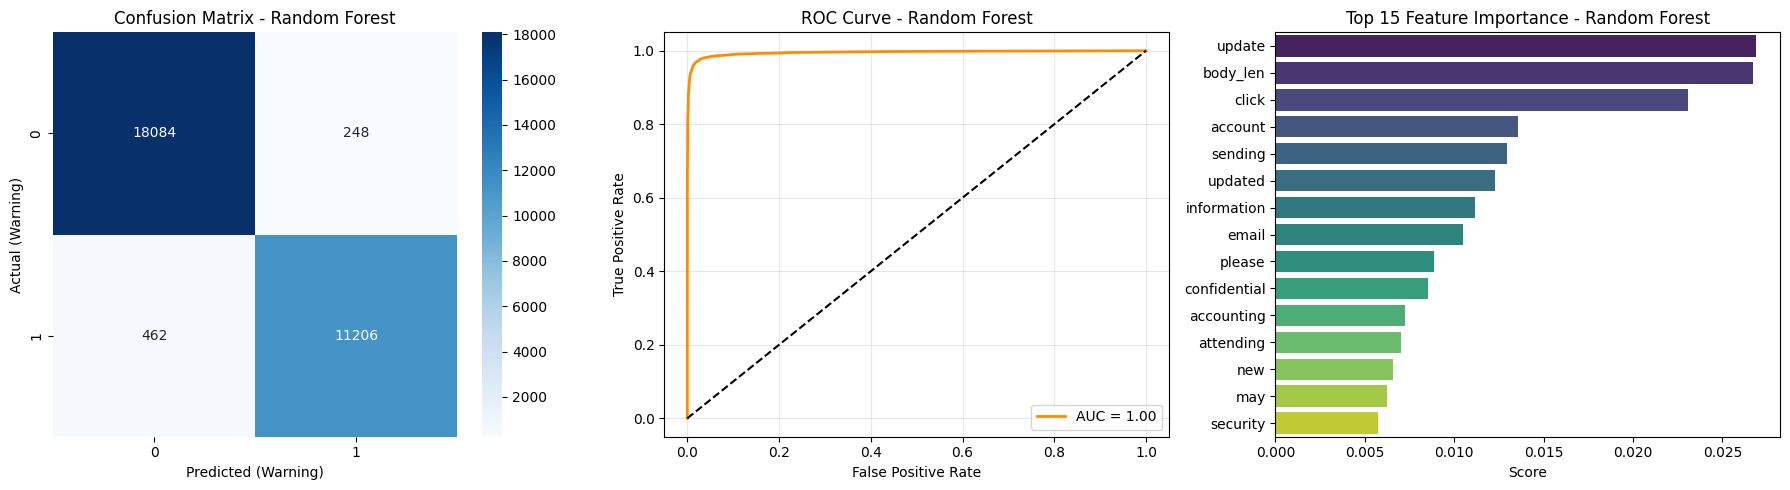

In [6]:
# Cell 6: Training & Evaluasi RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

print("[INFO] Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_final, y_train)

# Tampilkan Evaluasi Lengkap
_ = evaluate_and_visualize(rf_model, X_test_final, y_test, "Random Forest", all_feature_names)

## 10. XGBoost sebagai Model Supervised Utama

XGBoost digunakan sebagai model utama karena:
- Kemampuannya menangkap interaksi fitur yang kompleks
- Performa tinggi pada data berdimensi besar seperti TF-IDF

Parameter scale_pos_weight digunakan untuk mengoreksi ketidakseimbangan kelas secara matematis.

Model ini berperan sebagai pendeteksi utama pola ancaman yang sudah dikenal di dalam data pelatihan.


[INFO] Training XGBoost...

📊 MODEL REPORT: XGBoost
Accuracy  : 0.9592
Precision : 0.9912
Recall    : 0.9031
F1-Score  : 0.9451
ROC-AUC   : 0.9746



C:\Users\xande\AppData\Local\Temp\ipykernel_24276\417457655.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis', ax=axes[2])


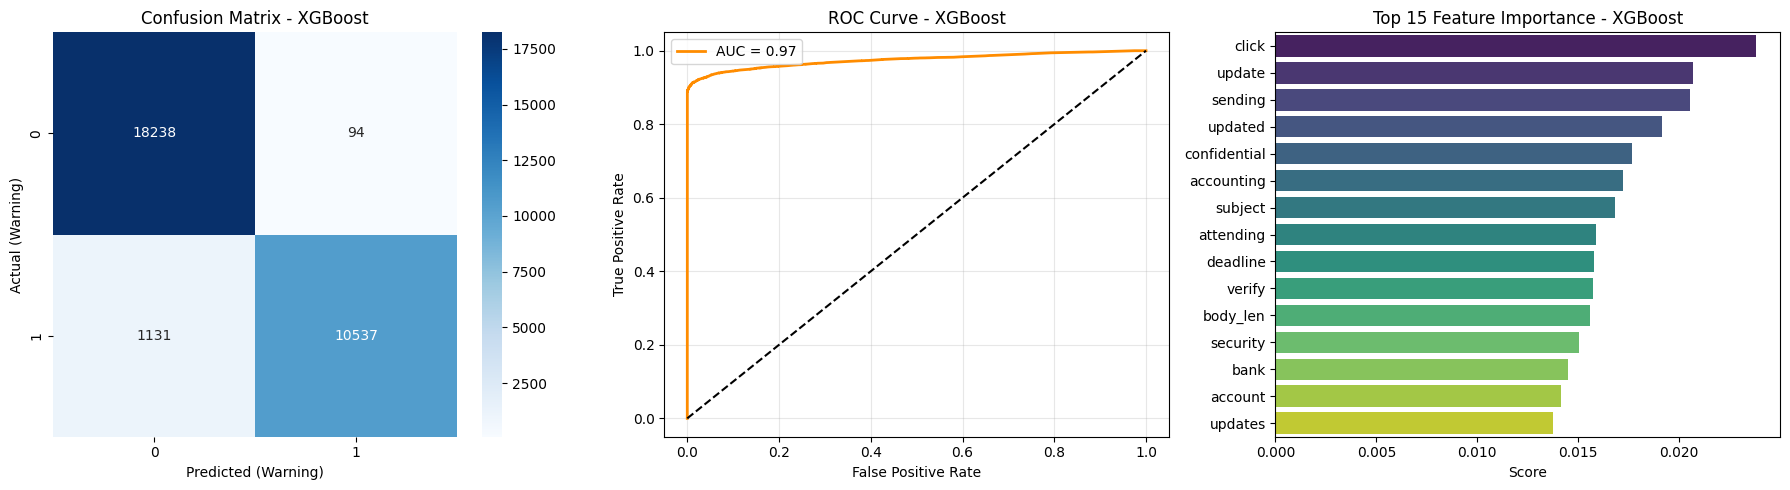

In [7]:
# Cell 7: Training & Evaluasi XGBOOST
from xgboost import XGBClassifier

print("[INFO] Training XGBoost...")
# Hitung rasio untuk imbalance class
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_final, y_train)

# Tampilkan Evaluasi Lengkap
_ = evaluate_and_visualize(xgb_model, X_test_final, y_test, "XGBoost", all_feature_names)

## 11. Isolation Forest sebagai Model Unsupervised Deteksi Anomali

Isolation Forest digunakan untuk mendeteksi email yang memiliki pola menyimpang dari distribusi normal.

Pendekatan ini penting karena:
- Tidak semua ancaman memiliki pola yang sudah dikenal
- Email zero-day dapat muncul di luar pola sebelumnya

Threshold ditentukan menggunakan optimasi F1-Score dari Precision-Recall Curve agar keseimbangan deteksi tetap terjaga.

Model ini berfungsi sebagai lapisan keamanan tambahan di luar model supervised.


[INFO] Training Isolation Forest (Unsupervised)...
[TUNING] Threshold Optimal ditemukan: -0.0328 (Max F1: 0.6579)

📊 MODEL REPORT: Isolation Forest (Tuned)
Accuracy  : 0.6888
Precision : 0.5746
Recall    : 0.7696
F1-Score  : 0.6579
ROC-AUC   : 0.7801



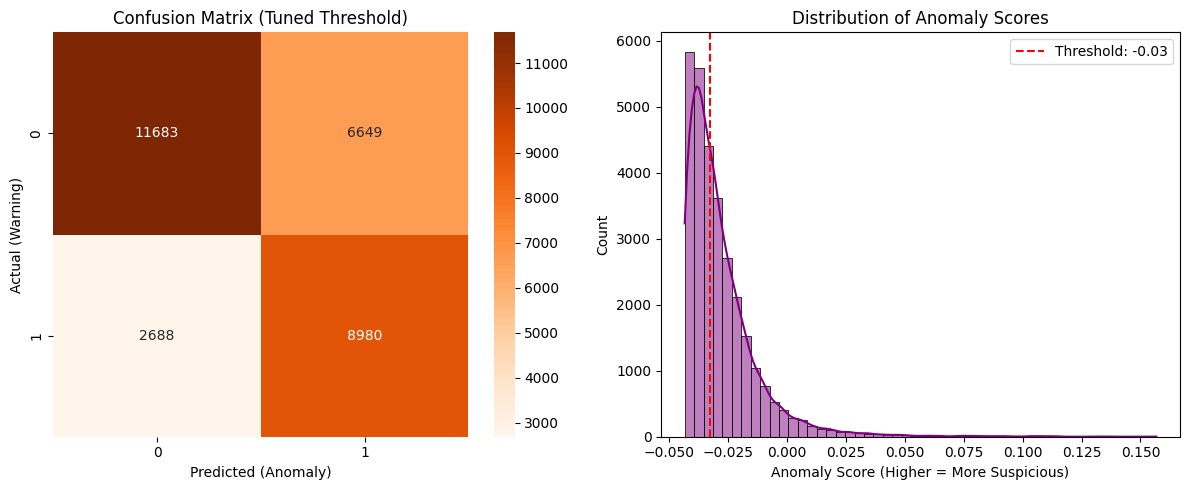

[INFO] Visualisasi Histogram menunjukkan distribusi skor. Garis merah adalah batas pemisah Anomali.


In [8]:
# Cell 8: Training & Evaluasi ISOLATION FOREST
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve

print("[INFO] Training Isolation Forest (Unsupervised)...")

# 1. Training Model
# Kita gunakan contamination agak rendah agar fokus ke outlier ekstrim dulu
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
iso_model.fit(X_train_final)

# 2. Ambil Anomaly Scores (Bukan prediksi langsung)
# decision_function: makin negatif = makin anomali
# Kita balik tandanya (-) supaya makin besar = makin anomali (untuk memudahkan thresholding)
y_scores = -iso_model.decision_function(X_test_final)

# 3. Threshold Tuning (Mencari batas terbaik)
# Kita cari threshold yang memaksimalkan F1-Score agar hasil tidak 0.00
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores) # Handle division by zero

# Ambil index F1 tertinggi
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"[TUNING] Threshold Optimal ditemukan: {best_threshold:.4f} (Max F1: {best_f1:.4f})")

# 4. Buat Prediksi Baru berdasarkan Threshold Optimal
y_pred_iso = [1 if score >= best_threshold else 0 for score in y_scores]

# 5. Evaluasi Hasil Akhir
print(f"\n{'='*40}")
print(f"📊 MODEL REPORT: Isolation Forest (Tuned)")
print(f"{'='*40}")
print(f"Accuracy  : {accuracy_score(y_test, y_pred_iso):.4f}")
print(f"Precision : {precision_score(y_test, y_pred_iso):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred_iso):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred_iso):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_scores):.4f}")
print(f"{'='*40}\n")

# 6. Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# A. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0])
axes[0].set_title('Confusion Matrix (Tuned Threshold)')
axes[0].set_xlabel('Predicted (Anomaly)')
axes[0].set_ylabel('Actual (Warning)')

# B. Histogram Skor Anomali
sns.histplot(y_scores, bins=50, kde=True, ax=axes[1], color='purple')
axes[1].axvline(best_threshold, color='red', linestyle='--', label=f'Threshold: {best_threshold:.2f}')
axes[1].set_title('Distribution of Anomaly Scores')
axes[1].set_xlabel('Anomaly Score (Higher = More Suspicious)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("[INFO] Visualisasi Histogram menunjukkan distribusi skor. Garis merah adalah batas pemisah Anomali.")


🕵️ ANALISIS KESALAHAN (ERROR ANALYSIS)
Jumlah False Positives (Salah Tuduh) : 94
Jumlah False Negatives (Kecolongan)  : 1131
----------------------------------------

>>> CONTOH FALSE POSITIVE (Top 3 berdasarkan confidence model):

[1] Subject: True Orange, September 4, 2001, Part 3
    Risk Score: 0.6848
    Snippet   : Part 3 of 3 Parts  Note to E-Mail Subscribers:  I published a roster in the mail version of my newsletter. If you have the UT media guide (the big, back-breaking thing) or if you went to the first gam...
    Clean Text: part parts note email subscribers published roster mail version newsletter ut media guide big backbr...

[2] Subject: Important - Energy Steps for Workers
    Risk Score: 0.6804
    Snippet   : Dear SVMG Member:  I need your help.  We will only limit the impact of this summer's Energy Crisis if all Californian's make gigantic strides to reduce energy use.  With that in mind, Governor Davis a...
    Clean Text: dear svmg member need help limit impact su

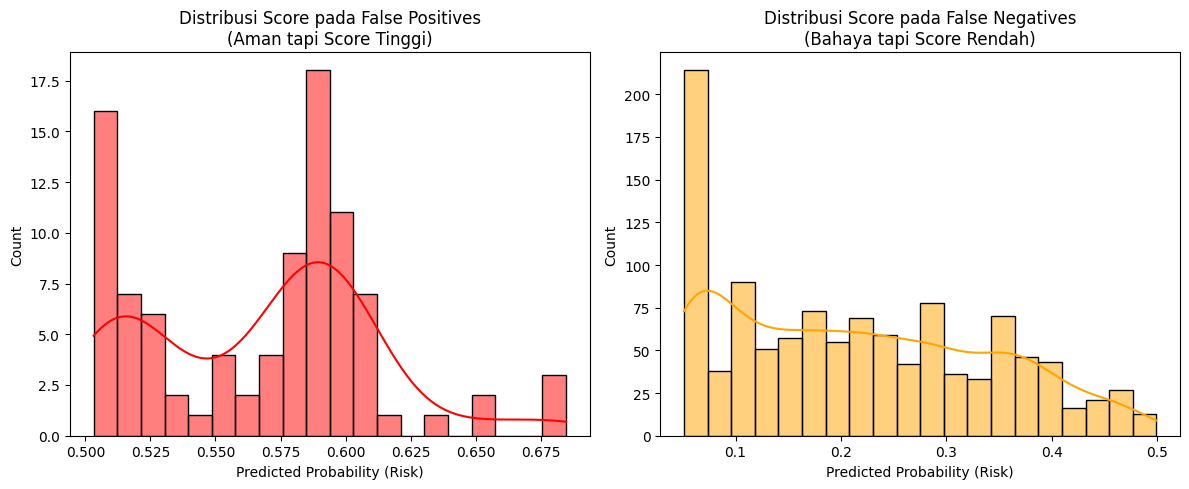

In [ ]:
# Cell 9: Analisis Kesalahan (Error Analysis)

print(f"\n{'='*40}")
print(f"🕵️ ANALISIS KESALAHAN (ERROR ANALYSIS)")
print(f"{'='*40}")

# 1. Rekonstruksi Data Test dengan Label Asli dan Prediksi
# Kita menggunakan index dari y_test untuk mengambil kembali teks asli dari df_parsed
test_indices = y_test.index
df_analysis = df_parsed.loc[test_indices][['subject', 'body', 'clean_text']].copy()

# Masukkan Label Asli dan Hasil Prediksi Model (gunakan XGBoost sebagai acuan utama)
df_analysis['Actual_Label'] = y_test
df_analysis['Predicted_Label'] = xgb_model.predict(X_test_final)
df_analysis['Risk_Probability'] = xgb_model.predict_proba(X_test_final)[:, 1]

# 2. Identifikasi False Positives dan False Negatives
# False Positive (FP): Model bilang BAHAYA (1), Padahal AMAN (0) -> "Salah Tuduh"
df_fp = df_analysis[(df_analysis['Actual_Label'] == 0) & (df_analysis['Predicted_Label'] == 1)]

# False Negative (FN): Model bilang AMAN (0), Padahal BAHAYA (1) -> "Kecolongan"
df_fn = df_analysis[(df_analysis['Actual_Label'] == 1) & (df_analysis['Predicted_Label'] == 0)]

print(f"Jumlah False Positives (Salah Tuduh) : {len(df_fp)}")
print(f"Jumlah False Negatives (Kecolongan)  : {len(df_fn)}")
print("-" * 40)

# 3. Fungsi untuk Menampilkan Contoh Kesalahan
def print_error_samples(df, error_type, n=3):
    print(f"\n>>> CONTOH {error_type} (Top {n} berdasarkan confidence model):")
    if df.empty:
        print("Tidak ada data untuk kategori ini.")
        return
    
    # Urutkan: FP berdasarkan probabilitas tertinggi (sangat yakin salah), FN berdasarkan probabilitas terendah
    if error_type == "FALSE POSITIVE":
        sorted_df = df.sort_values(by='Risk_Probability', ascending=False).head(n)
    else:
        sorted_df = df.sort_values(by='Risk_Probability', ascending=True).head(n)

    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        print(f"\n[{i+1}] Subject: {row['subject']}")
        print(f"    Risk Score: {row['Risk_Probability']:.4f}")
        # Tampilkan 200 karakter pertama body agar tidak terlalu panjang
        snippet = str(row['body']).replace('\n', ' ')[:200] + "..."
        print(f"    Snippet   : {snippet}")
        print(f"    Clean Text: {row['clean_text'][:100]}...")

# Tampilkan Contoh
print_error_samples(df_fp, "FALSE POSITIVE") # Email aman yang dikira ancaman
print_error_samples(df_fn, "FALSE NEGATIVE") # Email ancaman yang lolos

# 4. Visualisasi Distribusi Probabilitas Kesalahan
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot False Positives
plt.subplot(1, 2, 1)
if not df_fp.empty:
    sns.histplot(df_fp['Risk_Probability'], color='red', kde=True, bins=20)
    plt.title('Distribusi Score pada False Positives\n(Aman tapi Score Tinggi)')
    plt.xlabel('Predicted Probability (Risk)')
else:
    plt.text(0.5, 0.5, 'No False Positives', ha='center')

# Plot False Negatives
plt.subplot(1, 2, 2)
if not df_fn.empty:
    sns.histplot(df_fn['Risk_Probability'], color='orange', kde=True, bins=20)
    plt.title('Distribusi Score pada False Negatives\n(Bahaya tapi Score Rendah)')
    plt.xlabel('Predicted Probability (Risk)')
else:
    plt.text(0.5, 0.5, 'No False Negatives', ha='center')

plt.tight_layout()
plt.show()

## 12. Rasionalisasi Modul Mitigasi & SOAR

Penambahan simulasi mitigasi ini bertujuan untuk menjembatani **Model Machine Learning** dengan **Operasional Keamanan Dunia Nyata**:

1.  **Actionability (Dapat Dieksekusi)**
   : Model AI hanya menghasilkan angka probabilitas (misal: 0.89). Modul ini menerjemahkannya menjadi **instruksi tegas** (seperti *Block Domain* atau *Quarantine*) yang dapat dipahami oleh Firewall atau Email Gateway.

2.  **Pertahanan Berlapis (Defense in Depth)**
   : Mengimplementasikan strategi **Hybrid**: Jika model Supervised (XGBoost) gagal mendeteksi serangan baru, model Unsupervised (Isolation Forest) akan memberikan **penalti skor** jika data terdeteksi sebagai anomali (*Zero-Day*).

3.  **Efisiensi Operasional (Simulasi SOAR)**
   : Dalam lingkungan korporat dengan ribuan email/hari, analis tidak mungkin memeriksa manual satu per satu. Kode ini mensimulasikan **Otomatisasi** untuk memprioritaskan penanganan hanya pada kasus berisiko tinggi.

4.  **Safety Net (Jaring Pengaman)**
   : Model AI bersifat probabilistik dan bisa salah. Logika heuristik (aturan manual untuk kata kunci fatal seperti "kill" + "money") ditambahkan untuk memastikan ancaman eksplisit **pasti diblokir** tanpa kompromi.

5. Untuk simulasi lebih lanjut, akan dibuatkan ke dalam model aplikasi `streamlit`.

In [ ]:
# Cell 10: Simulasi Mitigasi Otomatis (SOAR Simulation) - FIXED

import pandas as pd
import numpy as np
import re

# 1. Definisi Fungsi Ekstraksi Domain
def extract_domain(text):
    match = re.search(r'[\w\.-]+@([\w\.-]+\.[\w\.-]+)', str(text))
    if match:
        return match.group(1).lower()
    return None 

# 2. Definisi Logika Risk Scoring
def run_mitigation_engine(row_text, xgb_prob, iso_score, iso_threshold):
    # --- A. ALERT SCORING SYSTEM (0 - 100) ---
    risk_score = xgb_prob * 100
    
    is_anomaly = iso_score >= iso_threshold
    if is_anomaly:
        risk_score += 15 
        
    if 'kill' in row_text and 'money' in row_text:
        risk_score = 100

    risk_score = min(risk_score, 100)
    
    # --- B. MITIGATION POLICY ---
    action = "ALLOW"
    status_color = "green"
    
    if risk_score >= 85:
        action = "BLOCK_DOMAIN_&_DELETE"
        status_color = "red"
    elif risk_score >= 50:
        action = "QUARANTINE_EMAIL"
        status_color = "orange"
    else:
        action = "MONITOR_ONLY"
        status_color = "blue"
        
    if risk_score < 20:
        action = "ALLOW"
        status_color = "green"

    return risk_score, action, is_anomaly

# 3. Menjalankan Simulasi
print("[INFO] Menjalankan Simulasi Mitigasi pada Data Test...")

# Ambil data test (100 sampel)
test_indices = y_test.index[:100]
sample_data = df_parsed.loc[test_indices].copy()

# --- BAGIAN YANG DIPERBAIKI ADA DI SINI ---
# Kita konversi ke CSR (Compressed Sparse Row) dulu baru di-slice [:100]
sample_features = X_test_final.tocsr()[:100] 
# ------------------------------------------

# Get Probabilities & Scores
xgb_probs = xgb_model.predict_proba(sample_features)[:, 1]
iso_scores = -iso_model.decision_function(sample_features)

# Siapkan list hasil
simulation_results = []
blocked_domains = set()

for i, (idx, row) in enumerate(sample_data.iterrows()):
    text_content = row['clean_text']
    current_xgb = xgb_probs[i]
    current_iso = iso_scores[i]
    
    score, action, anomaly = run_mitigation_engine(
        text_content, 
        current_xgb, 
        current_iso, 
        best_threshold
    )
    
    domain = extract_domain(row['body'])
    if "BLOCK" in action and domain:
        blocked_domains.add(domain)
    
    simulation_results.append({
        'Date': row['date'],
        'Subject': str(row['subject'])[:30] + '...',
        'Risk_Score': round(score, 2),
        'AI_Confidence': round(current_xgb, 4),
        'Is_Anomaly': anomaly,
        'Action_Taken': action,
        'Suspect_Domain': domain if domain else "N/A"
    })

# Buat DataFrame Laporan
df_report = pd.DataFrame(simulation_results)

# 4. Tampilkan Hasil
print(f"\n{'='*60}")
print("🛡️  SOC AUTOMATED RESPONSE REPORT")
print(f"{'='*60}")

print("\n[SUMMARY] Distribusi Tindakan yang Diambil:")
print(df_report['Action_Taken'].value_counts())

print(f"\n[BLOCKED] Domain yang dimasukkan ke Blacklist ({len(blocked_domains)}):")
print(list(blocked_domains)[:10])

print(f"\n[DETAIL] Contoh Email yang di-BLOCK atau QUARANTINE:")
high_risk_cases = df_report[df_report['Risk_Score'] > 50].head(5)

if not high_risk_cases.empty:
    display(high_risk_cases[['Subject', 'Risk_Score', 'Action_Taken', 'Suspect_Domain']])
else:
    print("Tidak ada sampel berisiko tinggi dalam batch ini.")

[INFO] Menjalankan Simulasi Mitigasi pada Data Test...

🛡️  SOC AUTOMATED RESPONSE REPORT

[SUMMARY] Distribusi Tindakan yang Diambil:
Action_Taken
ALLOW                    36
MONITOR_ONLY             33
BLOCK_DOMAIN_&_DELETE    27
QUARANTINE_EMAIL          4
Name: count, dtype: int64

[BLOCKED] Domain yang dimasukkan ke Blacklist (11):
['enron.com.', 'dowjones.com', 'duke-energy.com', 'aol.com', 'worldnet.att.net', 'enron.com', 'bigplanet.com', 'yahoo.com', 'venturewire.com', 'haas.berkeley.edu']

[DETAIL] Contoh Email yang di-BLOCK atau QUARANTINE:


,Subject,Risk_Score,Action_Taken,Suspect_Domain
0,NWP System Notice - 01-15 Soli...,100.0,BLOCK_DOMAIN_&_DELETE,N/A
1,Important Information About Se...,100.0,BLOCK_DOMAIN_&_DELETE,enron.com.
3,Re: Disbanding of Joel Henenbe...,100.0,BLOCK_DOMAIN_&_DELETE,N/A
13,"VentureWire People, Tuesday, N...",100.0,BLOCK_DOMAIN_&_DELETE,venturewire.com
15,Your Approval is Overdue: Acce...,100.0,BLOCK_DOMAIN_&_DELETE,enron.com


## 13. Penyimpanan Model untuk Deployment

Model dan preprocessing tools yang disimpan:
- XGBoost sebagai detektor utama
- Isolation Forest sebagai detektor anomali
- TF-IDF Vectorizer
- MinMax Scaler

Penyimpanan ini penting agar:
- Proses inferensi di aplikasi Streamlit identik dengan proses training
- Tidak terjadi perbedaan distribusi data saat runtime
- Prediksi tetap valid secara statistik

Tanpa menyimpan preprocessing tools, hasil prediksi tidak akan konsisten.


In [ ]:
# Cell 11: Save ALL Model Artifacts for Deployment
import joblib

print("[INFO] Saving all model artifacts...")

# 1. Simpan Model XGBoost (Supervised - Pola Dikenal)
joblib.dump(xgb_model, 'xgb_model_final.pkl')

# 2. Simpan Model Isolation Forest (Unsupervised - Anomali/Zero-Day)
joblib.dump(iso_model, 'iso_model_final.pkl')

# 3. Simpan Vectorizer & Scaler (Preprocessing Tools)
joblib.dump(vectorizer, 'tfidf_vec_final.pkl')
joblib.dump(scaler, 'scaler_final.pkl')

print("[SUCCESS] Semua file berhasil disimpan: xgb, iso, vec, scaler.")

[INFO] Saving all model artifacts...
[SUCCESS] Semua file berhasil disimpan: xgb, iso, vec, scaler.
